In [148]:
from copy import deepcopy

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from IPython.display import clear_output

from pyelq.component.background import SpatioTemporalBackground
from pyelq.component.error_model import BySensor
from pyelq.component.offset import PerSensor
from pyelq.component.source_model import Normal
from pyelq.coordinate_system import ENU, LLA
from pyelq.dispersion_model.finite_volume import FiniteVolume, FiniteVolumeDimension
from pyelq.gas_species import CH4
from pyelq.model import ELQModel
from pyelq.meteorology import Meteorology
from pyelq.meteorology_windfield import MeteorologyWindfield, SiteLayout
from pyelq.plotting.plot import Plot
from pyelq.preprocessing import Preprocessor
from pyelq.sensor.beam import Beam
from pyelq.sensor.sensor import Sensor, SensorGroup
from pyelq.source_map import SourceMap


# How to use finite volume dispersion model in pyELQ
This example is intended to provide an overview on how to use the finite volume dispersion model in pyELQ. We advise to take a look at the basic example first which is based on the Gaussian plume dispersion model. 

We will set up an example where we generate some concentration data using finite volume dispersion model and try to estimate the source location and emisson rate of these synthetic sources.

Finally we plot the various results.

In [172]:
time_axis = pd.array(
    pd.date_range(start="2024-01-01 08:00:00", end="2024-01-01 08:30:00", freq="10s"), dtype="datetime64[ns]"
)
nof_observations = time_axis.size
reference_latitude = 0
reference_longitude = 0
reference_altitude = 0

radius = 30
nof_beam_sensors = 5
angles = np.linspace(0, 90, nof_beam_sensors)
sensor_x_beam = radius * np.cos(angles * np.pi / 180)
sensor_y_beam = radius * np.sin(angles * np.pi / 180)
sensor_z_beam = np.ones_like(sensor_x_beam) * 5.0

sensor_group = SensorGroup()
for sensor in range(nof_beam_sensors):
    new_sensor = Beam()
    new_sensor.label = f"Beam sensor {sensor}"
    new_sensor.location = ENU(
        east=np.array([0, sensor_x_beam[sensor]]),
        north=np.array([0, sensor_y_beam[sensor]]),
        up=np.array([5.0, sensor_z_beam[sensor]]),
        ref_latitude=reference_latitude,
        ref_longitude=reference_longitude,
        ref_altitude=reference_altitude
    )

    new_sensor.time = time_axis
    new_sensor.concentration = np.zeros(nof_observations)
    sensor_group.add_sensor(new_sensor)

nof_point_sensors = 2
sensor_x = np.array([5, 20])
sensor_y = np.array([22, 5])
sensor_z = np.ones_like(sensor_x) * 5.0

for sensor in range(nof_point_sensors):
    new_sensor = Sensor()
    new_sensor.label = f"Point sensor {sensor}"
    new_sensor.location = ENU(
        east=sensor_x[sensor],
        north=sensor_y[sensor],
        up=sensor_z[sensor],
        ref_latitude=reference_latitude,
        ref_longitude=reference_longitude,
        ref_altitude=reference_altitude
    )

    new_sensor.time = time_axis
    new_sensor.concentration = np.zeros(nof_observations)
    sensor_group.add_sensor(new_sensor)


source_map_initial = SourceMap()
site_limits = np.array([[0, 30], [0, 30], [0, 10]])

source_map_initial.location  = ENU(
    ref_latitude=reference_latitude, ref_longitude=reference_longitude, ref_altitude=reference_altitude
)

# adjusted these to make sure they are at cell centres in the FV grid.
source_map_initial.location.east = np.array([7.5, 4.5])
source_map_initial.location.north = np.array([4.5, 10.5])
source_map_initial.location.up = np.array([1.0, 1.0])

gas_object = CH4()

In [150]:
fig = go.Figure()
fig = sensor_group.plot_sensor_location(fig=fig)
fig.update_layout(
    map_style="open-street-map",
    map_center=dict(lat=reference_latitude, lon=reference_longitude),
    map_zoom=18,
    height=800,
    margin={"r": 0, "l": 0, "b": 0},
)
fig.show()

Next we simulate meteorology observation, i.e., wind speed and wind direction (equivalently u and v components). There is a difference between the generation of the meteorology observations for Gaussian plume (example_basic.ipynb) and Finite Volume which comes down to the the nature of these dispersion models and their sensitivity to wind variablity. **Gaussian Plume** Model assumes steady-state conditions over the averaging period. It works best when wind speed and direction are relatively constant, so using a simple deterministic trend (like a linear change plus Gaussian noise) is sufficient. This keeps the inversion stable and computationally efficient because the model expects smooth meteorological inputs. **Finite Volume** Dispersion Model, on the other hand, solves the time-dependent advection–diffusion equation on a grid. It explicitly tracks how the gas move and mix over time, so the wind field needs to reflect realistic short-term variability and turbulence. The Ornstein–Uhlenbeck process is ideal here because it introduces correlated random fluctuations with mean reversion, mimicking atmospheric turbulence without making the wind completely random. This ensures the simulation captures the stochastic nature of wind while remaining physically plausible.

The following code snippet simulates the evolution of wind components using an Ornstein–Uhlenbeck process. The process introduces two effects: a drift term that pulls the wind vector toward zero (mean reversion) and a diffusion term that adds random fluctuations scaled by a noise parameter. Starting from an initial wind speed and direction, the model iteratively updates the horizontal (u, v) and vertical (w) wind components over time. This approach captures realistic variability in wind fields while maintaining physical consistency, making it useful for dispersion or turbulence simulations. The parameter **tau** controls how quickly the wind components revert toward their mean state. A smaller tau means faster reversion, while a larger tau allows the wind to persist longer before drifting back. The parameter **sigma** determines the strength of random variability added to the wind components. Larger sigma values produce more turbulent, erratic changes, while smaller values keep the wind smoother. Different sigma values for horizontal and vertical components reflect that vertical wind typically varies less than horizontal wind.


In [151]:
# obs_delta_t = (time_axis[1] - time_axis[0]).total_seconds()

# tau = np.array([100, 100, 100]).reshape(-1, 1) * obs_delta_t
# sigma = np.array([1.0, 1.0, 0.1]).reshape(-1, 1)

# met_object = Meteorology()
# met_object.time = time_axis
# met_object.wind_speed = np.full((nof_observations), np.nan)
# met_object.wind_direction = np.full((nof_observations), np.nan)
# met_object.u_component = np.full((nof_observations), np.nan)
# met_object.v_component = np.full((nof_observations), np.nan)
# met_object.w_component = np.full((nof_observations), np.nan)
# met_object.wind_speed[0] = 2.0
# met_object.wind_direction[0] = 270.0
# met_object.calculate_uv_from_wind_speed_direction()
# met_object.w_component[0] = 0.0
# for iT in range(nof_observations - 1):
#     wind_vector_iT = np.array([met_object.u_component[iT],
#                                met_object.v_component[iT],
#                                met_object.w_component[iT]]).reshape(-1, 1)
#     dx = - wind_vector_iT / tau * obs_delta_t + sigma * np.sqrt(2 * obs_delta_t / tau) * np.random.normal(size=sigma.shape)
#     met_object.u_component[iT + 1] = wind_vector_iT[0] + dx[0]
#     met_object.v_component[iT + 1] = wind_vector_iT[1] + dx[1]
#     met_object.w_component[iT + 1] = wind_vector_iT[2] + dx[2]

# met_object.calculate_wind_speed_from_uv()
# met_object.calculate_wind_direction_from_uv()
# met_object.temperature = (273.1 + 15.0) * np.ones_like(met_object.wind_direction)
# met_object.pressure = 101.325 * np.ones_like(met_object.wind_direction)


In [152]:
# alternative using a circle of wind directions
met_object = Meteorology()
met_object.time = time_axis

met_object.wind_speed = np.linspace(2.0, 4.0, nof_observations)
met_object.wind_direction = np.linspace(0, 180, nof_observations)
met_object.calculate_uv_from_wind_speed_direction()
met_object.w_component = 0.0 * np.random.normal(size=nof_observations)
met_object.temperature = (273.1 + 15.0) * np.ones_like(met_object.wind_direction)
met_object.pressure = 101.325 * np.ones_like(met_object.wind_direction)

In [153]:
fig_wind = met_object.plot_polar_hist()
fig_wind.update_layout(height=400, margin={"r": 0, "l": 0})
fig_wind.show()


In [154]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=met_object.time, y=met_object.wind_direction, name="Wind Direction"))


Normally these raw datasets need some preprocessing like making that the sensor_object and met_object do not contain nan values and that the wind speeds are larger than the lower limit. Therefore we created the preprocessor class which removes the nan values from these objects. We also show the functionality to apply a wind fil an aggregate function on the data within the user specified time bins and also show how to apply a wind filter.

In [155]:
preprocessor_object = Preprocessor(
    sensor_object=sensor_group, met_object=met_object, time_bin_edges=None
)
preprocessor_object.filter_on_met_without_regularization(
    filter_variable=["wind_speed"], lower_limit=[0.01], upper_limit=[np.inf]
)

### Defining the Site Layout with Obstacles
Now we define the sitelayout with obstacles. The SiteLayout class represents cylindrical obstacles within the domain, which can influence wind flow and dispersion patterns. These obstacles are defined by their coordinates and radii:

- cylinders_coordinate: An ENU object specifying the east, north positions and height each cylinder relative to a reference latitude, longitude, and altitude.
- cylinders_radius: An array containing the radius of each cylinder.

In this example, two cylindrical obstacles are placed at:
(east=15, north=15, up=5) with radius 1 m
(east=20, north=5, up=7) with radius 2 m

These obstacles will later be used to mask grid cells within their radius, ensuring the dispersion model accounts for blocked regions when computing flow and coupling.


In [156]:
cylinders_coordinate = ENU(ref_latitude=reference_latitude,
                           ref_longitude=reference_longitude,
                           ref_altitude=reference_altitude
                           )
cylinders_coordinate.east = np.array([3, 13])
cylinders_coordinate.north = np.array([19, 2])
cylinders_coordinate.up = np.array([5, 7])
cylinders_radius = np.array([[2, 1]]).T

site_layout = SiteLayout(
    cylinders_coordinate=cylinders_coordinate, cylinders_radius=cylinders_radius
)
# site_layout = None


With the obstalces and the meteorology defined, we can now define MeteorologyWindfield representing the wind condition across the domain.
This represents a spatially resolved wind field based on meteorological measurements and the presence of obstacles in the environment factoring in obstacle perturbations using an analytical method. 


In [157]:
met_windfield = MeteorologyWindfield(static_wind_field=preprocessor_object.met_object,
                                     site_layout=site_layout)


## Forward Simulation

### Setting Up 2D Finite Volume Dimensions

For a forward we define a two-dimensional finite volume grid using a custom FiniteVolumeDimension data class. Each dimension—x, y is  characterized by the number of cells, spatial limits, and boundary conditions. For the x and y directions, we use 30 cells each and apply Dirichlet boundary conditions on the external boundaries, which typically fix the variable values at the domain edges. 

In [158]:
dimensions = [
    FiniteVolumeDimension(
        "x",
        number_cells=30,
        limits=site_limits[0],
        external_boundary_type=["dirichlet"],
    ),
    FiniteVolumeDimension(
        "y",
        number_cells=30,
        limits=site_limits[1],
        external_boundary_type=["dirichlet"],
    ),
]

The dimensions are passed into a FiniteVolume object. On initialisation this object defines a grid and works out the neighbourhood and boundary relationships used in the model

In [159]:
fe_forward = FiniteVolume(
    source_map=source_map_initial,
    dimensions=dimensions,
    diffusion_constants=diffusion_coefficients,
    minimum_contribution=1e-6,
    use_lookup_table=False,
    dt = 0.1,
    site_layout=site_layout
)

The wind field can be computed using the calculate_spatial_wind_field function at the gridcoordinates defined in the fe_forward object.

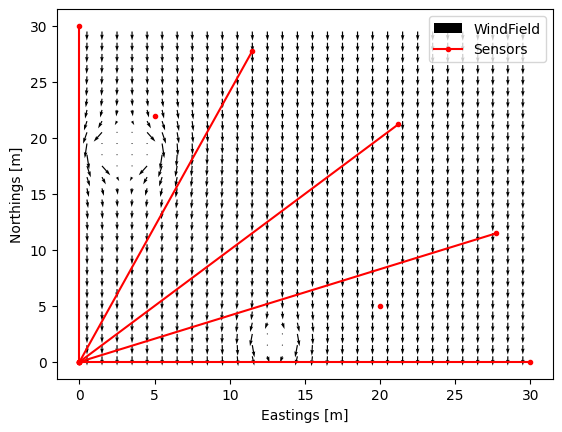

In [160]:
met_windfield.calculate_spatial_wind_field(grid_coordinates=fe_forward.grid_coordinates, time_index=0)

plt.quiver(
    fe_forward.grid_coordinates.east,
    fe_forward.grid_coordinates.north,
    met_windfield.u_component,
    met_windfield.v_component,
)
for sensor in sensor_group.values():    
    plt.plot(sensor.location.east,sensor.location.north,'r.-')
plt.xlabel('Eastings [m]')
plt.ylabel('Northings [m]')

plt.legend(['WindField','Sensors'])

The model is simulated forward by using the compute_forward_matrix function and a forward propogate loop. Emissions are added at a rate of 5.0 kg/hr at the location [10, 10] 

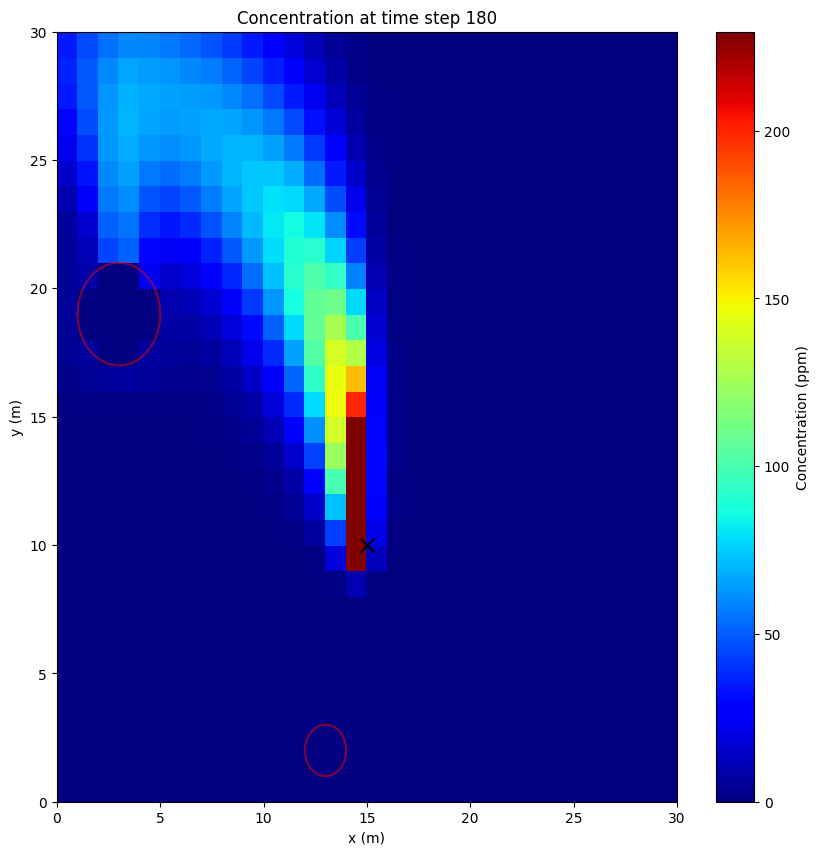

In [174]:
concentration = np.full((fe_forward.total_number_cells, met_object.nof_observations+1), np.nan)
concentration[:, 0] = 0.0
source_allocation = np.zeros((fe_forward.total_number_cells, 1), dtype=bool)
source_location = np.array([15, 10])
source_rate = 5.0  # kg/hr
tree = cKDTree(
    np.vstack(
        (fe_forward.grid_coordinates.east.flatten(), fe_forward.grid_coordinates.north.flatten())
    ).T
)
_, source_index = tree.query(source_location[:2], k=1)
source_allocation[source_index] = True

x_cylinder = np.linspace(-cylinders_radius, cylinders_radius, 100)
y_cylinder = np.sqrt(cylinders_radius**2 - x_cylinder**2)
y_cylinder = np.concatenate((y_cylinder, -y_cylinder[::-1]))
x_cylinder = np.concatenate((x_cylinder, x_cylinder[::-1]))


for iT in range(met_object.nof_observations):
    met_windfield.calculate_spatial_wind_field(grid_coordinates=fe_forward.grid_coordinates, time_index=iT)

    fe_forward.compute_forward_matrix(met_windfield)

    s_smoothed = source_allocation * source_rate / 3600

    concentration[:, iT + 1] = (fe_forward.dt / fe_forward.cell_volume) * (
        fe_forward.forward_matrix @ concentration[:, iT].reshape(-1, 1) + s_smoothed
    ).flatten()
  
    
    if iT % 3 == 0:
        concentration_scaled = concentration[:, iT + 1] * (1e6) / gas_object.gas_density()
        plt.figure(figsize=(10, 10))
        plt.pcolor(
                fe_forward.dimensions[0].cell_centers,
                fe_forward.dimensions[1].cell_centers,
                concentration_scaled.reshape(fe_forward.grid_size).T ,
                cmap="jet",
                shading="auto",
                vmin=np.min(concentration_scaled),
                vmax=0.5 * np.max(concentration_scaled),
            )
        plt.colorbar(label="Concentration (ppm)")
        plt.scatter(
            source_location[0],
            source_location[1],
            color="black",
            label="Source location",
            s=100,
            marker="x",
        )
        for i in range(len(cylinders_coordinate.east)):
                plt.plot(
                    (x_cylinder[:, i, :] + cylinders_coordinate.east[i]),
                    (y_cylinder[:, i, :] + cylinders_coordinate.north[i]),
                    c="red",
                    alpha=0.5,
                )
        plt.title("Concentration at time step {}".format(iT))
        
        plt.xlabel("x (m)")
        plt.ylabel("y (m)")
        plt.show()
        plt.pause(1e-6)    
        clear_output(wait=True)

### Setting Up 3D Finite Volume Dimensions

Next, we define a three-dimensional finite volume grid using a custom FiniteVolumeDimension data class. Each dimension—x, y, and z—is characterized by the number of cells, spatial limits, and boundary conditions. For the x and y directions, we use 10 cells each and apply Dirichlet boundary conditions on the external boundaries, which typically fix the variable values at the domain edges. The z direction is discretized into 5 cells and uses a mixed boundary condition: Neumann on one side (specifying the derivative or flux) and Dirichlet on the other. The site_limits array provides the physical bounds for each dimension, ensuring the grid spans the intended region of the computational domain.

Now we create an instance of the FiniteVolume dispersion model, which solves the advection–diffusion equation on the previously defined grid. This model uses the finite volume method to compute how the gas disperse within the domain. The initialization specifies:

1. source_map: Defines the source locations.
2. dimensions: The grid structure for each axis, as configured earlier.
3. diffusion_constants: Physical diffusion coefficients for each dimension.
4. minimum_contribution: A cutoff to ignore negligible coupling contributions.
5. use_lookup_table=False: If true the FiniteVolume class uses a lookup table for coupling matrix interpolation (this is used when the coupling matrix is calulated at the grid locations and needed to be interpolated on the sourcemap, when reversible jump option is used). 
6. sitelayout: the sitelayout defining the location and radii of the obstacles in the domain.

In [ ]:
diffusion_coefficients = np.array([0.1, 0.1, 1.0])
dispersion_model_initial = FiniteVolume(
    source_map=source_map_initial,
    dimensions=dimensions,
    diffusion_constants=diffusion_coefficients,
    minimum_contribution=1e-6,
    use_lookup_table=False,
    site_layout=site_layout
)

After defining the gas species, source_map, sensor_object, met_object, sitelayout and met_windfield, we set the true emission rates and generate the real observations. We calculate the coupling from each source to each sensor using finite volume dispersion model and multiply this coupling with the emission rates of the respective sources. We add this source contribution to the background (in this case 2.0 ppm) and also add some random (measurement) noise. These simulated observations are populating the concentration attribute of each sensor in the sensorgroup. The resulting data is shown in the plot.

In [ ]:
emission_rates = np.array([5.0, 3.0])

coupling_matrix = dispersion_model_initial.compute_coupling(
    sensor_object=preprocessor_object.sensor_object,
    met_windfield=met_windfield,
    gas_object=CH4(),
    output_stacked=False,
)

background_concentration = 2.0

for key, sensor in sensor_group.items():
    noise = np.random.normal(0, 0.1, size=(sensor.time.shape[0]))
    sensor.concentration = (
        coupling_matrix[key] @ emission_rates + background_concentration + noise
    )

In [ ]:
fig = go.Figure()
fig = sensor_group.plot_timeseries(fig=fig)
fig.update_layout(height=800, margin={"r": 0, "t": 10, "l": 0, "b": 0})
fig.show()

Next, we configure the Finite Volume dispersion model by passing in the source map, the grid dimensions defined earlier, and the diffusion coefficients. In this setup, the property use_lookup_table is set to True, which changes how coupling matrix are computed. Instead of recalculating the coupling matrix at every MCMC iteration, the solver first computes the coupling matrix at all grid locations for all time steps. These precomputed values are then interpolated to the source map locations during the algorithm’s execution. This approach significantly improves computational efficiency because the expensive finite volume calculations are performed only once, while subsequent iterations rely on fast interpolation.


In [ ]:
source_map = SourceMap()
source_map.location = ENU(ref_latitude=reference_latitude,
                          ref_longitude=reference_longitude,
                          ref_altitude=reference_altitude)

source_map.generate_sources(
    coordinate_object=source_map.location,
    sourcemap_limits=site_limits,
    sourcemap_type="hypercube",
    nof_sources=5,
)
dispersion_model = FiniteVolume(
    source_map=source_map,
    dimensions=dimensions,
    diffusion_constants=diffusion_coefficients,
    minimum_contribution=1e-6,
    use_lookup_table=True,
    site_layout=site_layout
)


## Inverse Emission Estimation

We set up the different parameters for our MCMC model. Since we defined 3 source maps, we need to defined 3 source models. We also set up a background model, offset model and error model to complete the MCMC setup.

In [ ]:
source_model = Normal()
source_model.emission_rate_mean = np.array([0], ndmin=1)
source_model.initial_precision = np.array([1 / (2.5**2)], ndmin=1)
source_model.reversible_jump = True
source_model.distribution_number_sources = "Poisson"
source_model.rate_num_sources = 1.0
source_model.dispersion_model = deepcopy(dispersion_model)
source_model.update_precision = False
source_model.site_limits = site_limits
source_model.coverage_detection = 0.1  # ppm
source_model.coverage_test_source = 3.0  # kg/hr

background = SpatioTemporalBackground()
background.n_time = None
background.mean_bg = 2.0
background.spatial_dependence = True
background.initial_precision = 1 / np.power(3e-4, 2)
background.precision_time_0 = 1 / np.power(0.1, 2)
background.spatial_correlation_param = 25.0
background.update_precision = False

offset_model = PerSensor()
offset_model.update_precision = False
offset_model.initial_precision = 1 / (0.001) ** 2

error_model = BySensor()
error_model.initial_precision = 1 / (0.1) ** 2
error_model.prior_precision_shape = 1e-2
error_model.prior_precision_rate = 1e-2

We create an instance of the ELQModel class which forms the interface with the MCMC repo and run the MCMC algorithm. Finally we plot the results

In [ ]:
elq_model = ELQModel(
    sensor_object=preprocessor_object.sensor_object,
    meteorology=met_windfield,
    gas_species=gas_object,
    background=background,
    source_model=source_model,
    error_model=error_model,
    offset_model=offset_model,
)
elq_model.n_iter = 5000

elq_model.initialise()

elq_model.to_mcmc()
elq_model.run_mcmc()
elq_model.from_mcmc()

This snippet is generating cylinder outlines for visualization in geographic coordinates (latitude/longitude) which is useful for visualizing obstacles or structures in the domain.

In [ ]:
def generate_cylinder_points(center_east, center_north, radius, num_points=100):
    """Generate ENU coordinates for a cylinder base centered at (east, north)."""
    x = np.linspace(-radius, radius, num_points)
    y = np.sqrt(radius **2 - x **2)
    x_full = np.concatenate((x, x[::-1]))
    y_full = np.concatenate((y, -y[::-1]))

    return np.column_stack((x_full + center_east, y_full + center_north, np.zeros_like(x_full)))


all_cylinders_locations = np.vstack([
    generate_cylinder_points(e, n, r)
    for e, n, r in zip(site_layout.cylinders_coordinate.east,
                       site_layout.cylinders_coordinate.north,
                       cylinders_radius)
])

cylinder_enu = ENU(
    ref_altitude=reference_altitude,
    ref_latitude=reference_latitude,
    ref_longitude=reference_longitude,
)
cylinder_enu.from_array(all_cylinders_locations)
cylinder_lla = cylinder_enu.to_lla()

cylinder_trace = go.Scattermap(
    mode="markers",
    lon=cylinder_lla.longitude,
    lat=cylinder_lla.latitude,
    marker={"color": "black"},
)

Finally plotting the results in a separate cell. Note that you can plot all plots in 1 go as well using `plotter.show_all()`

In [ ]:
burn_in = elq_model.n_iter - 2000

plotter = Plot()

plotter.plot_quantification_results_on_map(
    model_object=elq_model, bin_size_x=1.0, bin_size_y=1.0, normalized_count_limit=0.01, burn_in=burn_in
)

plotter.plot_fitted_values_per_sensor(
    mcmc_object=elq_model.mcmc, sensor_object=elq_model.sensor_object, burn_in=burn_in
)

true_source_location_trace = go.Scattermap(
    mode="markers",
    lon=source_map_initial.location.to_lla().longitude,
    lat=source_map_initial.location.to_lla().latitude,
    name="True locations",
    marker=go.scattermap.Marker(color="green", size=10),
)

In [ ]:
plotter = elq_model.plot_fitted_values(plot=plotter)
plotter.figure_dict["count_map"].add_trace(true_source_location_trace).update_traces(showlegend=True)
plotter.figure_dict["count_map"].add_trace(cylinder_trace).update_traces(showlegend=True)
plotter.figure_dict["count_map"].update_layout(height=800, margin={"r": 0, "t": 50, "l": 0, "b": 0}, map_zoom=19)
plotter.figure_dict["iqr_map"].add_trace(true_source_location_trace).update_traces(showlegend=True)
plotter.figure_dict["iqr_map"].add_trace(cylinder_trace).update_traces(showlegend=True)
plotter.figure_dict["iqr_map"].update_layout(height=800, margin={"r": 0, "t": 50, "l": 0, "b": 0}, map_zoom=19)
plotter.figure_dict["median_map"].add_trace(true_source_location_trace).update_traces(showlegend=True)
plotter.figure_dict["median_map"].add_trace(cylinder_trace).update_traces(showlegend=True)
plotter.figure_dict["median_map"].update_layout(height=800, margin={"r": 0, "t": 50, "l": 0, "b": 0}, map_zoom=19)
plotter = elq_model.plot_log_posterior(burn_in_value=burn_in, plot=plotter)
plotter = elq_model.components["source"].plot_iterations(plot=plotter, burn_in_value=burn_in, y_axis_type="linear")
plotter = elq_model.components["source"].plot_iterations(plot=plotter, burn_in_value=burn_in, y_axis_type="log")

plotter = elq_model.components["offset"].plot_iterations(
    plot=plotter, sensor_object=elq_model.sensor_object, burn_in_value=burn_in
)
plotter = elq_model.components["offset"].plot_distributions(
    plot=plotter, sensor_object=elq_model.sensor_object, burn_in_value=burn_in
)
plotter = elq_model.components["error_model"].plot_iterations(
    plot=plotter, sensor_object=elq_model.sensor_object, burn_in_value=burn_in
)
plotter = elq_model.components["error_model"].plot_distributions(
    plot=plotter, sensor_object=elq_model.sensor_object, burn_in_value=burn_in
)
plotter.show_all()